## Introduction
This project focuses on building a deep learning model for car image classification using **Transfer Learning**. The objective is to classify car images into **196 different categories** from the **Stanford Cars Dataset** using the **ResNet50** architecture pretrained on ImageNet.

**The workflow includes:**
* Data loading and preprocessing
* Data augmentation
* Visualization of training samples
* Model building using ResNet50
* Multi-stage training and fine-tuning
* Model evaluation using accuracy and classification metrics

## Dataset Description
The project uses the **Stanford Cars Dataset**, a benchmark dataset for fine-grained image classification.

**Dataset Details:**
* **Number of classes:** 196
* **Training images:** 8,144
* **Validation images:** 3,977
* **Test images:** 4,064
* **Dataset link:** [Stanford Car Dataset on Kaggle](https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder)

The dataset is organized into separate training and testing directories, with validation data split from the test set.

---

## Environment and Libraries
The following libraries and frameworks were used in this project:
* **TensorFlow / Keras**
* **NumPy**
* **Matplotlib**
* **Scikit-learn**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.metrics import classification_report


2025-12-17 22:01:03.307343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766008863.528023      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766008863.594000      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766008864.143268      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766008864.143321      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766008864.143324      24 computation_placer.cc:177] computation placer alr

---

## Data Loading and Directory Setup
The dataset directories were defined for training and testing.

**Key Parameters:**
* **Batch size:** 16
* **Image size:** 224 × 224

This image resolution matches the input requirements of **ResNet50**.

In [2]:
BASE_DIR = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR  = os.path.join(BASE_DIR, "test")

BATCH_SIZE = 16
IMG_SIZE = (224, 224)


---

## Image Preprocessing
Images were preprocessed using the ResNet50 `preprocess_input` function to ensure compatibility with the pretrained model.

**Preprocessing steps include:**
* Pixel normalization
* Channel-wise scaling

In [3]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.5
)


---

## Data Augmentation
To improve generalization and reduce overfitting, data augmentation was applied during training.

**Augmentation techniques used:**
* Random rotation
* Random zoom
* Horizontal flipping

These transformations increase dataset variability without changing labels.

In [4]:
train_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset="validation",
    class_mode="categorical",
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset="training",
    class_mode="categorical",
    shuffle=False
)

num_classes = train_data.num_classes
class_names = list(train_data.class_indices.keys())


Found 8144 images belonging to 196 classes.
Found 3977 images belonging to 196 classes.
Found 4064 images belonging to 196 classes.


---

## Data Visualization
### 1. Before Augmentation
A sample of training images was visualized before augmentation to:
* Verify correct image loading
* Confirm class labels
* Ensure data integrity

Found 8144 images belonging to 196 classes.


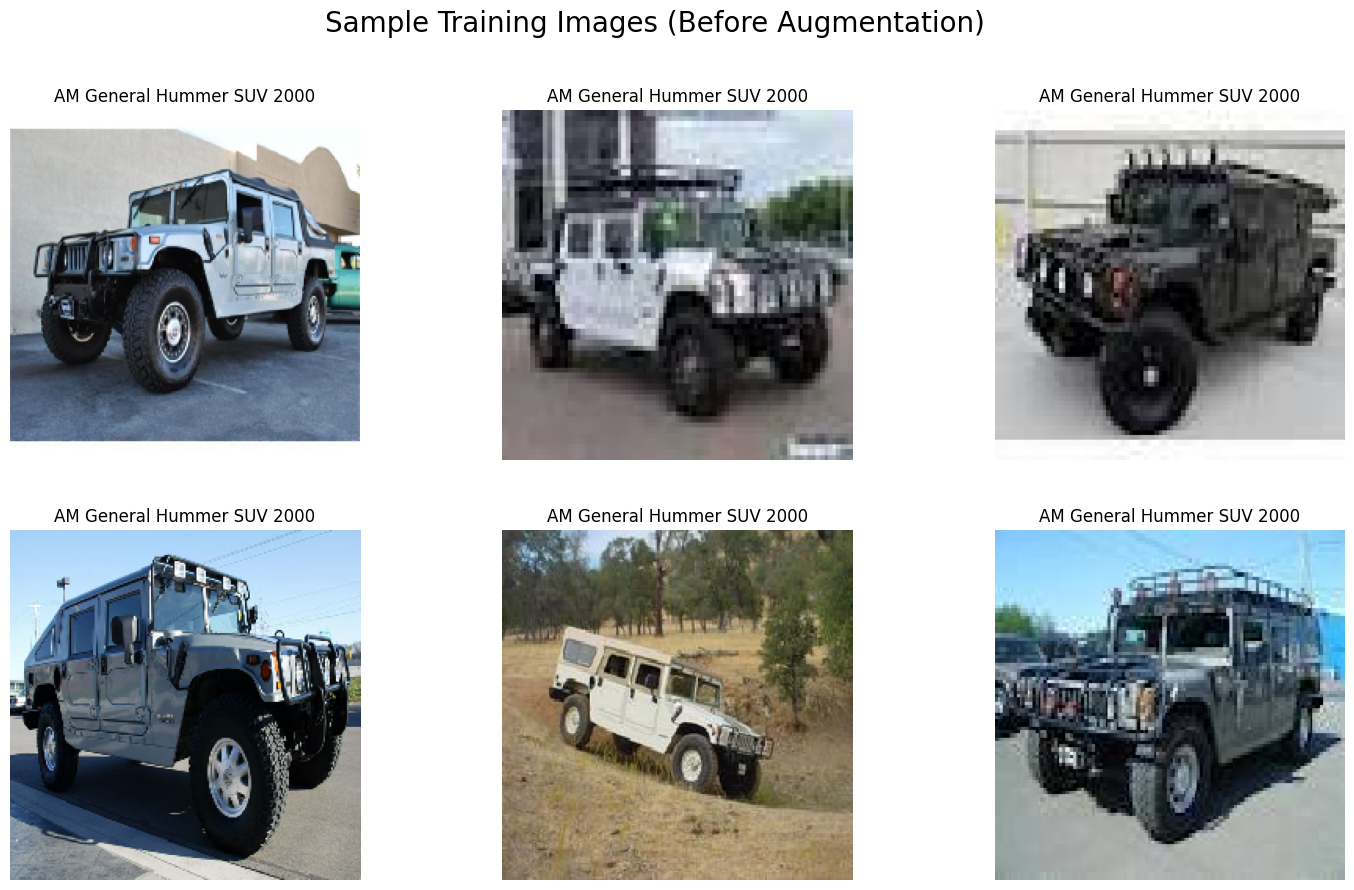

In [5]:
viz_gen = ImageDataGenerator()

viz_data = viz_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=6,
    class_mode="categorical",
    shuffle=False
)

images, labels = next(viz_data)

plt.figure(figsize=(18, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    class_idx = np.argmax(labels[i])
    plt.title(class_names[class_idx], fontsize=12)
    plt.axis("off")

plt.suptitle("Sample Training Images (Before Augmentation)", fontsize=20)
plt.show()


---

### 2. After Augmentation
Augmented versions of training images were visualized to:
* Observe the effect of augmentation
* Ensure transformations preserve semantic meaning
* Confirm augmentation is applied correctly

Found 8144 images belonging to 196 classes.


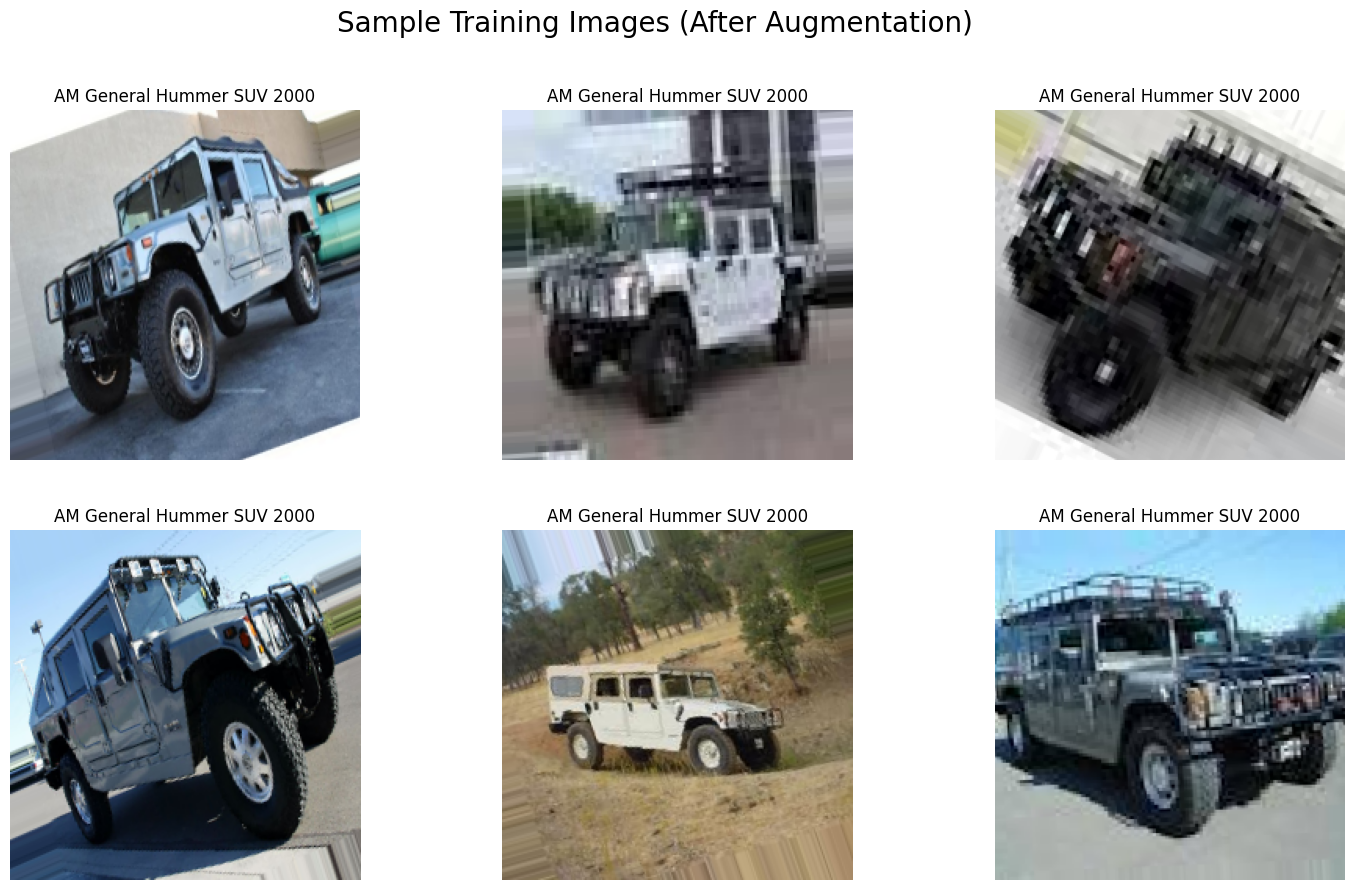

In [6]:
viz_aug_gen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

viz_aug_data = viz_aug_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=6,
    class_mode="categorical",
    shuffle=False
)

aug_images, aug_labels = next(viz_aug_data)

plt.figure(figsize=(18, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(aug_images[i].astype("uint8"))
    class_idx = np.argmax(aug_labels[i])
    plt.title(class_names[class_idx], fontsize=12)
    plt.axis("off")

plt.suptitle("Sample Training Images (After Augmentation)", fontsize=20)
plt.show()


---

## Model Architecture
The model is built using **ResNet50** as a backbone network.

**Architecture Components:**
1. **ResNet50** (pretrained on ImageNet, without top layers)
2. Global Average Pooling layer
3. Batch Normalization
4. Dropout layer (rate = 0.5)
5. Dense output layer with **Softmax** activation

The output layer contains **196 neurons**, one for each car class.

In [7]:
base = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation="softmax")(x)

model = Model(base.input, out)


I0000 00:00:1766008886.387266      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766008886.391259      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


---

## Model Compilation
The model was compiled using:
* **Optimizer:** Adam
* **Loss function:** Categorical Crossentropy
* **Metric:** Accuracy

An initial learning rate of `1e-3` was used for the first training stage.

## Training Strategy

### Stage 1 – Feature Extraction
* **Configuration:** All ResNet50 layers frozen; only the classification head was trained.
* **Epochs:** 15
* **Purpose:** To learn dataset-specific class boundaries while preserving pretrained features.

In [8]:
model.compile(
    optimizer=Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_data,
    validation_data=val_data,
    epochs=15
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1766008897.163722     108 service.cc:152] XLA service 0x793510004530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766008897.163757     108 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766008897.163764     108 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766008898.992014     108 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/509 ━━━━━━━━━━━━━━━━━━━━ 1:46:45 13s/step - accuracy: 0.0000e+00 - loss: 7.1370

I0000 00:00:1766008903.398544     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


509/509 ━━━━━━━━━━━━━━━━━━━━ 201s 370ms/step - accuracy: 0.0574 - loss: 5.6750 - val_accuracy: 0.2816 - val_loss: 3.2160
Epoch 2/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 128s 252ms/step - accuracy: 0.3196 - loss: 3.0121 - val_accuracy: 0.3654 - val_loss: 2.9128
Epoch 3/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 127s 250ms/step - accuracy: 0.4374 - loss: 2.3284 - val_accuracy: 0.3983 - val_loss: 2.7944
Epoch 4/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 132s 259ms/step - accuracy: 0.5138 - loss: 1.9514 - val_accuracy: 0.4154 - val_loss: 2.7718
Epoch 5/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 138s 272ms/step - accuracy: 0.5559 - loss: 1.7213 - val_accuracy: 0.4265 - val_loss: 2.8039
Epoch 6/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 133s 262ms/step - accuracy: 0.6042 - loss: 1.5689 - val_accuracy: 0.4393 - val_loss: 2.7692
Epoch 7/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 132s 259ms/step - accuracy: 0.6263 - loss: 1.4377 - val_accuracy: 0.4471 - val_loss: 2.8160
Epoch 8/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 128s 252ms/step - accuracy: 0.6291 - loss: 1.47

---

### Stage 2 – Full Fine-Tuning
* **Configuration:** All ResNet50 layers unfrozen.
* **Learning Rate:** Reduced to `1e-4`.
* **Epochs:** 15
* **Purpose:** To fine-tune the entire network for better feature adaptation.

In [9]:
base.trainable = True

model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_data,
    validation_data=val_data,
    epochs=15
)


Epoch 1/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 195s 280ms/step - accuracy: 0.4919 - loss: 2.4167 - val_accuracy: 0.4566 - val_loss: 3.1285
Epoch 2/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 135s 264ms/step - accuracy: 0.6826 - loss: 1.2911 - val_accuracy: 0.5466 - val_loss: 2.5080
Epoch 3/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 136s 267ms/step - accuracy: 0.7642 - loss: 0.9230 - val_accuracy: 0.5527 - val_loss: 2.4949
Epoch 4/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 137s 269ms/step - accuracy: 0.8097 - loss: 0.6959 - val_accuracy: 0.5914 - val_loss: 2.2456
Epoch 5/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 137s 269ms/step - accuracy: 0.8401 - loss: 0.5597 - val_accuracy: 0.6291 - val_loss: 1.9058
Epoch 6/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 137s 268ms/step - accuracy: 0.8676 - loss: 0.4730 - val_accuracy: 0.6208 - val_loss: 1.9734
Epoch 7/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 137s 268ms/step - accuracy: 0.8677 - loss: 0.4819 - val_accuracy: 0.6301 - val_loss: 2.0724
Epoch 8/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 137s 269ms/step - accuracy: 0.8662 -

---

### Callbacks
To improve training efficiency and stability, the following callbacks were used:
* `ModelCheckpoint`: To save the best-performing model.
* `EarlyStopping`: To prevent overfitting.
* `ReduceLROnPlateau`: To dynamically reduce learning rate.

### Stage 3 – Advanced Fine-Tuning
* **Configuration:** Continued fine-tuning with very low learning rate.
* **Learning Rate:** Reduced to `1e-5`.
* **Epochs:** 20
* **Purpose:** To achieve optimal convergence and maximize validation accuracy.

In [10]:
checkpoint = ModelCheckpoint(
    "resnet50_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model.compile(
    optimizer=Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,   
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/20
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9308 - loss: 0.2299
Epoch 1: val_accuracy improved from -inf to 0.75484, saving model to resnet50_best.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 194s 288ms/step - accuracy: 0.9308 - loss: 0.2298 - val_accuracy: 0.7548 - val_loss: 1.2373 - learning_rate: 1.0000e-05
Epoch 2/20
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9641 - loss: 0.1216
Epoch 2: val_accuracy improved from 0.75484 to 0.76490, saving model to resnet50_best.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 139s 273ms/step - accuracy: 0.9641 - loss: 0.1216 - val_accuracy: 0.7649 - val_loss: 1.1854 - learning_rate: 1.0000e-05
Epoch 3/20
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9684 - loss: 0.1054
Epoch 3: val_accuracy improved from 0.76490 to 0.77621, saving model to resnet50_best.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 139s 272ms/step - accuracy: 0.9684 - loss: 0.1054 - val_accuracy: 0.7762 - val_loss: 1.1553 - learning_rate: 1.0000e-05
Epoch 4/20
509/5

---

## Model Evaluation
After training, the best saved model was evaluated on the test dataset.

### Test Accuracy: **~80.0%**
This result demonstrates strong performance on unseen car images.

### Classification Report
A detailed classification report was generated including:
* Precision
* Recall
* F1-score

Metrics were calculated for all **196 classes**, providing insight into per-class performance and model strengths.

In [11]:
model.load_weights("resnet50_best.keras")

preds = model.predict(test_data)
y_pred = np.argmax(preds, axis=1)
y_true = test_data.classes

print("ResNet50 Test Accuracy:", np.mean(y_pred == y_true))
print(classification_report(y_true, y_pred, target_names=class_names))


254/254 ━━━━━━━━━━━━━━━━━━━━ 49s 178ms/step
ResNet50 Test Accuracy: 0.8004429133858267
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.85      1.00      0.92        22
                             Acura Integra Type R 2001       0.81      0.77      0.79        22
                                   Acura RL Sedan 2012       0.69      0.69      0.69        16
                                   Acura TL Sedan 2012       0.75      0.95      0.84        22
                                  Acura TL Type-S 2008       0.85      0.81      0.83        21
                                  Acura TSX Sedan 2012       0.83      0.50      0.62        20
                              Acura ZDX Hatchback 2012       0.93      0.70      0.80        20
              Aston Martin V8 Vantage Convertible 2012       0.72      0.78      0.75        23
                    Aston Martin V8 Vantage Coup

---

## Performance Analysis
**Observations from the results:**
* High accuracy achieved for many car classes.
* Misclassifications mainly occur between visually similar models.
* Fine-tuning significantly improved performance compared to feature extraction only.

---

## Conclusion
In this project:
* A robust car classification model was developed using **ResNet50**.
* **Transfer learning** enabled effective training on a fine-grained dataset.
* The final model achieved approximately **80% test accuracy**.
* Multi-stage training and careful learning rate scheduling were key to success.